In [1]:
%load_ext autotime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

time: 1.38 s (started: 2022-10-05 18:42:05 +08:00)


In [2]:
x = pickle.load(open('./data/fundamentals3.pkl', 'rb'))
y = pickle.load(open('./data/performance3.pkl', 'rb'))

time: 16 ms (started: 2022-10-05 18:42:07 +08:00)


Remember that our data started from Sep 2016 and runs all the way till Sep 2021.

In [3]:
x

,EV_EBIT,OI_NWCFA,PE,PB,PS,OI_IntExp,WorkingCap,ROE,ROCE,DE,DebtRatio,CashRatio,AssetTurnover,GPM,WC_TA,RE_TA,EBIT_TA,Equity_Liab
0,82.797844,0.054971,112.795556,3.347207,12.792295,11.437500,3.846561,0.029675,0.024383,0.835610,2.196731,2.422222,1.738654,0.529253,0.345137,0.781242,0.021427,1.196731
1,73.741818,0.064395,93.220476,3.642102,14.677638,12.875000,3.337925,0.039070,0.030812,0.830698,2.203807,2.057851,1.633997,0.537957,0.323425,-0.057546,0.026550,1.203807
2,85.881068,0.061131,109.984756,4.122857,16.367967,13.400000,3.201348,0.037486,0.030165,0.832229,2.201593,2.012637,1.632593,0.537205,0.325973,-0.049027,0.025699,1.201593
3,93.118058,0.057908,112.367543,4.264654,17.651993,15.461538,3.219984,0.037953,0.029345,0.791585,2.263288,2.065270,1.555866,0.535009,0.333495,-0.031473,0.024936,1.263288
4,89.891130,0.063609,125.146780,4.581382,18.629924,17.923077,3.300871,0.036608,0.033366,0.742709,2.346422,2.120348,1.570674,0.544155,0.344885,-0.014954,0.028365,1.346422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34497,190.226788,0.162071,263.172831,29.454035,41.218524,600.000000,4.955648,0.111919,0.132893,0.363616,3.750153,2.809967,13.838362,0.789181,0.647814,0.552518,0.111129,2.750153
34498,401.544454,0.027134,455.367693,11.194813,30.310853,281.800000,7.889376,0.024584,0.024432,0.198130,6.047194,5.651679,11.991617,0.785479,0.773617,0.333149,0.021689,5.047194
34499,206.724364,0.041892,278.735919,8.760902,19.453274,459.400000,6.229416,0.031431,0.035773,0.269457,4.711162,3.871998,13.301299,0.778988,0.733024,0.324628,0.030759,3.711162
34500,-451.177169,-0.020088,-738.189122,9.281098,21.600759,-120.111111,6.530220,-0.012573,-0.017744,0.250797,4.987290,3.589801,10.494563,0.756041,0.733442,0.323538,-0.015391,3.987290


time: 31 ms (started: 2022-10-05 18:42:07 +08:00)


In [4]:
# Store the target returns temporarily
returns = y['Returns']
returns

0        0.563351
1        0.535595
2        0.198018
3        0.076426
4       -0.050044
           ...   
34497   -0.325537
34498        None
34499        None
34500        None
34501        None
Name: Returns, Length: 34502, dtype: object

time: 0 ns (started: 2022-10-05 18:42:07 +08:00)


In [13]:
# Add the Returns column to fundamentals data
x['Returns'] = returns

# Drop the null rows and reset index
x = x.dropna(axis=0)
x = x.reset_index(drop=True)

# Randomise the rows for train-test-split
# Specify frac=1 because we want all the rows back
x = x.sample(frac=1, random_state=42)

time: 16 ms (started: 2022-10-05 18:46:51 +08:00)


After randomizing the rows in the x dataframe (with the targets), we want to split back dataset into x and y

In [15]:
x

,EV_EBIT,OI_NWCFA,PE,PB,PS,OI_IntExp,WorkingCap,ROE,ROCE,DE,DebtRatio,CashRatio,AssetTurnover,GPM,WC_TA,RE_TA,EBIT_TA,Equity_Liab,Returns
9512,32.724455,0.064202,9.584927,0.121936,0.339259,16.066902,5.067293,0.012722,0.012362,0.565309,2.768945,0.404822,0.292376,0.278886,0.135672,0.000000,0.011950,1.768945,0.099574
14921,-1.272701,-0.138996,-8.105136,1.184655,77.920702,-9.563390,10.498345,-0.146161,-0.117468,0.212700,5.701463,9.827846,0.140365,0.000000,0.811986,-0.916485,-0.107426,4.701463,-0.525967
21084,-27.545762,-0.088592,-39.053543,2.543200,48.567042,600.000000,4.769410,-0.065121,-0.048791,0.526781,2.898322,4.405363,0.828104,0.000000,0.474251,-1.033298,-0.042652,1.898322,0.072747
3806,84.872614,0.016215,73.519538,1.712488,7.884209,2.439306,0.833413,0.023293,0.011532,2.678019,1.373410,0.137989,0.096655,0.549748,-0.015981,0.151307,0.010425,0.373410,0.220782
14240,-10.332471,-1.117864,-11.278592,13.175571,500.000000,600.000000,1.600097,-1.168193,-0.961274,1.171207,1.853820,1.156178,0.000000,0.000000,0.264214,-12.986173,-0.538039,0.853820,-0.658763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,207.639319,0.007757,418.636342,2.323661,16.447432,3.197531,1.202277,0.005551,0.007750,1.014564,1.985645,0.218039,0.093048,0.521155,0.032639,0.530154,0.006499,0.985645,0.013279
5390,76.132303,0.435791,125.575952,22.489452,27.634250,-600.000000,1.863233,0.179090,0.273337,0.689965,2.449348,0.929198,7.612553,0.594792,0.325749,0.633834,0.170191,1.449348,-0.289272
860,39.473384,0.038893,60.337081,1.846309,7.217758,7.504373,3.666572,0.030600,0.030977,0.695518,2.437778,2.204802,0.328654,0.338780,0.245203,0.096695,0.028128,1.437778,-0.381609
15795,-29.066823,-0.022881,-57.353712,1.004608,4.734679,600.000000,6.585545,-0.017516,-0.015981,0.156114,7.405561,3.916149,6.930668,0.455029,0.654460,-5.452373,-0.014109,6.405561,-0.381818


time: 16 ms (started: 2022-10-05 18:46:59 +08:00)


In [16]:
y = x['Returns']
X = x.drop(columns='Returns')

time: 0 ns (started: 2022-10-05 18:47:10 +08:00)


In [17]:
y.head()

9512     0.099574
14921   -0.525967
21084    0.072747
3806     0.220782
14240   -0.658763
Name: Returns, dtype: object

time: 15 ms (started: 2022-10-05 18:47:13 +08:00)


In [18]:
X.head()

,EV_EBIT,OI_NWCFA,PE,PB,PS,OI_IntExp,WorkingCap,ROE,ROCE,DE,DebtRatio,CashRatio,AssetTurnover,GPM,WC_TA,RE_TA,EBIT_TA,Equity_Liab
9512,32.724455,0.064202,9.584927,0.121936,0.339259,16.066902,5.067293,0.012722,0.012362,0.565309,2.768945,0.404822,0.292376,0.278886,0.135672,0.000000,0.011950,1.768945
14921,-1.272701,-0.138996,-8.105136,1.184655,77.920702,-9.563390,10.498345,-0.146161,-0.117468,0.212700,5.701463,9.827846,0.140365,0.000000,0.811986,-0.916485,-0.107426,4.701463
21084,-27.545762,-0.088592,-39.053543,2.543200,48.567042,600.000000,4.769410,-0.065121,-0.048791,0.526781,2.898322,4.405363,0.828104,0.000000,0.474251,-1.033298,-0.042652,1.898322
3806,84.872614,0.016215,73.519538,1.712488,7.884209,2.439306,0.833413,0.023293,0.011532,2.678019,1.373410,0.137989,0.096655,0.549748,-0.015981,0.151307,0.010425,0.373410
14240,-10.332471,-1.117864,-11.278592,13.175571,500.000000,600.000000,1.600097,-1.168193,-0.961274,1.171207,1.853820,1.156178,0.000000,0.000000,0.264214,-12.986173,-0.538039,0.853820


time: 0 ns (started: 2022-10-05 18:47:14 +08:00)


In [19]:
# Just checking on the baseline annual returns
y.mean()

0.2525233262311256

time: 0 ns (started: 2022-10-05 18:47:18 +08:00)


# Model 1: Linear Regression

In [20]:
# We can try with a 80-20 train test split first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('X train: ', X_train.shape)
print('X test: ', X_test.shape)
print('y train: ', y_train.shape)
print('y test: ', y_test.shape)

X train:  (21348, 18)
X test:  (5337, 18)
y train:  (21348,)
y test:  (5337,)
time: 0 ns (started: 2022-10-05 18:47:20 +08:00)


In [21]:
pl = Pipeline([
    ('PowerTransform', PowerTransformer()),
    ('lr', LinearRegression())
])

time: 0 ns (started: 2022-10-05 18:47:21 +08:00)


In [22]:
pl.fit(X_train, y_train)
y_pred = pl.predict(X_test)

time: 375 ms (started: 2022-10-05 18:47:21 +08:00)


In [23]:
mse_train = mean_squared_error(y_train, pl.predict(X_train), squared=True)
mse_test = mean_squared_error(y_test, y_pred, squared=True)
pct_diff = round((1-mse_test/mse_train)*100,3)

print('Train MSE:', mse_train)
print('Test MSE:', mse_test)
print(f'Generalisation: {pct_diff}%')

Train MSE: 1.728141511801339
Test MSE: 1.466730735008862
Generalisation: 15.127%
time: 15 ms (started: 2022-10-05 18:47:21 +08:00)


We construct the learning curve for the model (where we increase size of learning set and see how predictive ability changes). Cross validation can either be K-fold or ShuffleSplit(), where we randomize rows before the train-test-split. This gives us a better idea of the predictive ability as we are averaging many runs.

In [24]:
trainSizes = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.9]

train_sizes, train_scores, test_scores, fit_times, score_times = \
learning_curve(pl, X, y, cv=ShuffleSplit(n_splits=100,
                                         test_size=0.2,
                                         random_state=42),
               scoring='neg_mean_squared_error',
               n_jobs=-1, train_sizes=trainSizes,
               return_times=True)

# Create a DataFrame of results
results_df = pd.DataFrame(index=trainSizes)
results_df['train_scores_mean'] = np.sqrt(-np.mean(train_scores,axis=1))
results_df['train_scores_std'] = np.std(np.sqrt(-train_scores), axis=1)
results_df['test_scores_mean'] = np.sqrt(-np.mean(test_scores, axis=1))
results_df['test_scores_std'] = np.std(np.sqrt(-test_scores), axis=1)
results_df['fit_times_mean'] = np.mean(fit_times, axis=1)
results_df['fit_times_std'] = np.std(fit_times, axis=1)
results_df # see results

,train_scores_mean,train_scores_std,test_scores_mean,test_scores_std,fit_times_mean,fit_times_std
0.01,1.161020,0.641632,298059.495017,272487.326958,0.041582,0.007271
0.02,1.276673,0.638205,129766.086455,119174.114998,0.047693,0.005713
0.05,1.250085,0.464826,47652.369607,45339.868482,0.066172,0.008087
0.10,1.257658,0.358527,13654.785359,13267.123791,0.096683,0.009219
0.20,1.260015,0.266152,4948.308848,4888.956767,0.152570,0.011039
0.50,1.303404,0.171492,3.377420,2.731218,0.322781,0.016877
0.90,1.294651,0.094120,1.338339,0.299332,0.540443,0.031796


time: 20.2 s (started: 2022-10-05 18:47:21 +08:00)


Text(0.5, 1.0, 'Linear Regression Learning Curve')

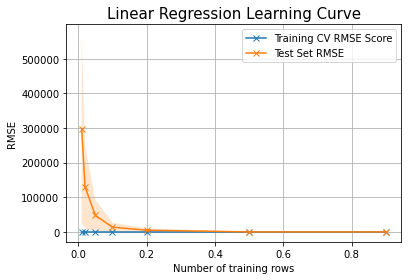

time: 140 ms (started: 2022-10-05 18:47:42 +08:00)


In [25]:
results_df['train_scores_mean'].plot(style='-x')
results_df['test_scores_mean'].plot(style='-x')

plt.fill_between(results_df.index,\
results_df['train_scores_mean']-results_df['train_scores_std'],\
results_df['train_scores_mean']+results_df['train_scores_std'],\
alpha=0.2)

plt.fill_between(results_df.index,\
results_df['test_scores_mean']-results_df['test_scores_std'],\
results_df['test_scores_mean']+results_df['test_scores_std'],\
alpha=0.2)

plt.grid()
plt.legend(['Training CV RMSE Score','Test Set RMSE'])
plt.ylabel('RMSE')
plt.xlabel('Number of training rows')
plt.title('Linear Regression Learning Curve', fontsize=15)
#plt.ylim([0, 1.25]);

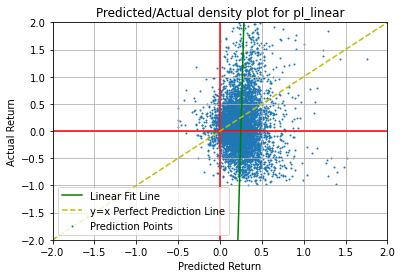

time: 281 ms (started: 2022-10-05 18:47:42 +08:00)


In [26]:
# Output scatter plot and contour plot of density of points to see
# if prediciton matches reality
# Line of x=y is provided, perfect prediction would have all density
# on this line
# Also plot linear regression of the scatter

def plotDensityContourPredVsReal(model_name, x_plot, y_plot, ps):
    # Plotting scatter
    plt.scatter(x_plot, y_plot, s=1)
    
    # Plotting linear regression
    # Swap X and Y fit because prediction is quite centered
    # around one value.

    LinMod = LinearRegression().fit(y_plot.reshape(-1, 1), \
    x_plot.reshape(-1, 1))
    xx=[[-5],[5]]
    yy=LinMod.predict(xx)
    plt.plot(yy,xx,'g')
    
    # Plot formatting
    plt.grid()
    plt.axhline(y=0, color='r', label='_nolegend_')
    plt.axvline(x=0, color='r', label='_nolegend_')
    plt.xlabel('Predicted Return')
    plt.ylabel('Actual Return')
    plt.plot([-100,100],[-100,100],'y--')
    plt.xlim([-ps,ps])
    plt.ylim([-ps,ps])
    plt.title('Predicted/Actual density plot for {}'.format(model_name))
    plt.legend(['Linear Fit Line',\
    'y=x Perfect Prediction Line','Prediction Points'])

plotDensityContourPredVsReal('pl_linear', y_pred, y_test.to_numpy(), 2)

In [28]:
y_results

,Actual Return,Predicted Return
0,1.333333,1.754325
1,-0.5,1.518118
2,-0.666667,1.482648
3,1.333333,1.430179
4,-0.75,1.394452
...,...,...
5332,0.114339,-0.462093
5333,0.185939,-0.477916
5334,0.074001,-0.496763
5335,0.197931,-0.497785


time: 0 ns (started: 2022-10-05 18:50:09 +08:00)


In [27]:
# See top 10 predicted annual returns and see how the values differ from actual
# Put results in a DataFrame so we can sort it.

y_results = pd.DataFrame()
y_results['Actual Return'] = y_test
y_results['Predicted Return'] = y_pred

# Sort df by the predicted returns.

y_results.sort_values(by='Predicted Return',
                      ascending=False,
                      inplace=True)
y_results.reset_index(drop=True, inplace=True)

print('Predicted Returns:', \
      list(np.round(y_results['Predicted Return'].iloc[:10],2)))

print('Actual Returns:', \
      list(np.round(y_results['Actual Return'].iloc[:10],2)), '\n')

print('Top 10 Predicted Returns:', \
      round(y_results['Predicted Return'].iloc[:10].mean(),2) , '%')

print('Actual Top 10 Returns:', \
      round(y_results['Actual Return'].iloc[:10].mean(),2) , '%','\n')

# See bottom 10 stocks and see how the values differ
print('Bottom 10 Predicted Returns:', \
      round(y_results['Predicted Return'].iloc[-10:].mean(),2) , '%')

print('Actual Bottom 10 Returns:', \
      round(y_results['Actual Return'].iloc[-10:].mean(),2) , '%','\n')

Predicted Returns: [1.75, 1.52, 1.48, 1.43, 1.39, 1.39, 1.36, 1.33, 1.29, 1.29]


TypeError: loop of ufunc does not support argument 0 of type float which has no callable rint method

time: 31 ms (started: 2022-10-05 18:47:42 +08:00)


In [ ]:
def observePredictionAbility(my_pipeline, X, y, returnSomething=False, verbose=True):
    '''
    For a given predictor pipeline.
    Create table of top10/bottom 10 averaged, 
    10 rows of 10 random_states.
    to give us a synthetic performance result.    
    Prints Top and Bottom stock picks
    
    The arguments returnSomething=False, verbose=True,
    will be used at the notebook end to get results.
    '''
    Top10PredRtrns, Top10ActRtrns=[], []
    Bottom10PredRtrns, Bottom10ActRtrns=[], []

    for i in range (0, 10): # Can try 100
        # Pipeline and train/test
        X_train, X_test, y_train, y_test =\
        train_test_split(X, y, test_size=0.1, random_state=42+i)
        my_pipeline.fit(X_train, y_train)
        y_pred = my_pipeline.predict(X_test)
        
        # Put results in a DataFrame so we can sort it.
        y_results = pd.DataFrame()
        y_results['Actual Return'] = y_test
        y_results['Predicted Return'] = y_pred
        
        # Sort it by the prediced return.
        y_results.sort_values(by='Predicted Return',
                              ascending=False,
                              inplace=True)
        y_results.reset_index(drop=True,
                              inplace=True)
        
        
         # See top 10 stocks and see how the values differ
        Top10PredRtrns.append(
            round(np.mean(y_results['Predicted Return'].iloc[:10])*100,
                  2))
        Top10ActRtrns.append(
            round(np.mean(y_results['Actual Return'].iloc[:10])*100,
                  2))
        
        # See bottom 10 stocks and see how the values differ
        Bottom10PredRtrns.append(
            round(np.mean(y_results['Predicted Return'].iloc[-10:])*100,
                  2))
        Bottom10ActRtrns.append(
            round(np.mean(y_results['Actual Return'].iloc[-10:])*100,
                  2))

    if verbose:
        print('Predicted Performance of Top 10 Return Portfolios:', 
              Top10PredRtrns)
        print('Actual Performance of Top 10 Return Portfolios:', 
              Top10ActRtrns,'\n')
        print('Predicted Performance of Bottom 10 Return Portfolios:', 
              Bottom10PredRtrns)
        print('Actual Performance of Bottom 10 Return Portfolios:', 
              Bottom10ActRtrns)
        print('--------------\n')
        
        print('Mean Predicted Std. Dev. of Top 10 Return Portfolios:',
              round(np.array(Top10PredRtrns).std(),2))
        print('Mean Actual Std. Dev. of Top 10 Return Portfolios:',
              round(np.array(Top10ActRtrns).std(),2))
        print('Mean Predicted Std. Dev. of Bottom 10 Return Portfolios:',
              round(np.array(Bottom10PredRtrns).std(),2))
        print('Mean Actual Std. Dev. of Bottom 10 Return Portfolios:',
              round(np.array(Bottom10ActRtrns).std(),2))
        print('--------------\n')
        
        #PERFORMANCE MEASURES HERE
        print(\
        '\033[4mMean Predicted Performance of Top 10 Return Portfolios:\033[0m',\
              round(np.mean(Top10PredRtrns), 2))
        print(\
        '\t\033[4mMean Actual Performance of Top 10 Return Portfolios:\033[0m',\
              round(np.mean(Top10ActRtrns), 2))
        print('Mean Predicted Performance of Bottom 10 Return Portfolios:',\
              round(np.mean(Bottom10PredRtrns), 2))
        print('\tMean Actual Performance of Bottom 10 Return Portfolios:',\
              round(np.mean(Bottom10ActRtrns), 2))
        print('--------------\n')
    
    if returnSomething:
        # Return the top10 and bottom 10 predicted stock return portfolios
        # (the actual performance)
        return Top10ActRtrns, Bottom10ActRtrns
    
    pass

In [ ]:
observePredictionAbility(pl, X, y)